# Custom CNN used to generate data for the report

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

DATA_DIR = '/home/ravindu/Documents/Projects/cnn-realwaste/realwaste/RealWaste'

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [7]:
# Dataset parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 9
NUM_EPOCHS = 20

# Class names
CLASS_NAMES = [
    'Cardboard',
    'Food Organics',
    'Glass',
    'Metal',
    'Miscellaneous Trash',
    'Paper',
    'Plastic',
    'Textile Trash',
    'Vegetation'
]

class WasteDataset(Dataset):
    """Custom Dataset for loading waste material images"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []

        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                image_files = sorted(class_dir.glob('*.*'))
                for img_path in image_files:
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.images.append(str(img_path))
                        self.labels.append(class_idx)

        if len(self.images) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label

def calculate_mean_std(dataset_path, image_size=224, sample_size=None):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    temp_dataset = WasteDataset(root_dir=dataset_path, transform=transform)

    if sample_size and sample_size < len(temp_dataset):
        indices = np.random.choice(len(temp_dataset), sample_size, replace=False)
        temp_dataset = Subset(temp_dataset, indices)

    loader = DataLoader(temp_dataset, batch_size=32, shuffle=False, num_workers=4)

    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0

    for images, _ in loader:
        channels_sum += torch.mean(images, dim=[0, 2, 3]) * images.size(0)
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3]) * images.size(0)
        num_pixels += images.size(0)

    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean ** 2)

    return mean.tolist(), std.tolist()

In [8]:
print("\n" + "="*70)
print("CALCULATING DATASET STATISTICS")
print("="*70)
dataset_mean, dataset_std = calculate_mean_std(DATA_DIR, IMAGE_SIZE, sample_size=1000)
print(f"Dataset Mean: {dataset_mean}")
print(f"Dataset Std: {dataset_std}")

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7,1.0), ratio=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.15),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.2), ratio=(0.3,3.3))
])

val_test_transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.15)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

print("\n" + "="*70)
print("LOADING AND SPLITTING DATASET")
print("="*70)

from sklearn.model_selection import StratifiedShuffleSplit

# Check if split indices already exist
if os.path.exists('split_indices.npz'):
    print("\n✅ Loading existing split indices from split_indices.npz")
    indices_file = np.load('split_indices.npz')
    train_idx = indices_file['train']
    val_idx = indices_file['val']
    test_idx = indices_file['test']
    print(f"  Train: {len(train_idx)} samples")
    print(f"  Val:   {len(val_idx)} samples")
    print(f"  Test:  {len(test_idx)} samples")
else:
    print("\n📂 Creating new split indices...")
    
    train_ratio = 0.70
    val_ratio = 0.15
    test_ratio = 0.15

    full_dataset = WasteDataset(root_dir=DATA_DIR, transform=None)
    labels = np.array([full_dataset[i][1] for i in range(len(full_dataset))])

    # First split: train vs (val + test)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
    train_idx, temp_idx = next(sss1.split(np.arange(len(labels)), labels))

    # Second split: val vs test
    temp_labels = labels[temp_idx]
    relative_test_size = test_ratio / (val_ratio + test_ratio)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=relative_test_size, random_state=42)
    val_idx_rel, test_idx_rel = next(sss2.split(np.arange(len(temp_idx)), temp_labels))

    val_idx = temp_idx[val_idx_rel]
    test_idx = temp_idx[test_idx_rel]

    # Save indices for future use
    np.savez('split_indices.npz', train=train_idx, val=val_idx, test=test_idx)
    print(f"✅ Split indices saved to split_indices.npz")
    print(f"  Train: {len(train_idx)} samples")
    print(f"  Val:   {len(val_idx)} samples")
    print(f"  Test:  {len(test_idx)} samples")

# Create datasets with transforms
full_dataset = WasteDataset(root_dir=DATA_DIR, transform=None)
train_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=train_transform)
val_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)
test_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)

train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(val_dataset_full, val_idx)
test_dataset = Subset(test_dataset_full, test_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=2, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=2, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True, drop_last=False)

print(f"\n✅ Data loaders created")

# Calculate class weights
from collections import Counter
labels = np.array([full_dataset[i][1] for i in range(len(full_dataset))])
train_labels = labels[train_idx].tolist()
class_counts = Counter(train_labels)

total_train = len(train_labels)
class_weights = torch.tensor(
    [total_train / (NUM_CLASSES * class_counts[i]) for i in range(NUM_CLASSES)],
    dtype=torch.float32
).to(device)



CALCULATING DATASET STATISTICS
Dataset Mean: [0.5958589315414429, 0.6181400418281555, 0.6327119469642639]
Dataset Std: [0.1614437848329544, 0.1623637080192566, 0.18791130185127258]

LOADING AND SPLITTING DATASET

📂 Creating new split indices...
✅ Split indices saved to split_indices.npz
  Train: 3326 samples
  Val:   713 samples
  Test:  713 samples

✅ Data loaders created


In [12]:
print("\n" + "="*70)
print("BUILDING WASTENET-DEEP ARCHITECTURE")
print("="*70)

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock(nn.Module):
    """Residual Block with Batch Normalization"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out


class PyramidPooling(nn.Module):
    """Pyramid Pooling Module"""
    def __init__(self, in_channels):
        super(PyramidPooling, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d(1)
        self.pool2 = nn.AdaptiveAvgPool2d(2)
        self.pool3 = nn.AdaptiveAvgPool2d(4)
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, in_channels // 4, 1, bias=False)
        self.conv3 = nn.Conv2d(in_channels, in_channels // 4, 1, bias=False)

    def forward(self, x):
        size = x.size()[2:]
        feat1 = nn.functional.interpolate(self.conv1(self.pool1(x)), size=size, 
                                         mode='bilinear', align_corners=True)
        feat2 = nn.functional.interpolate(self.conv2(self.pool2(x)), size=size,
                                         mode='bilinear', align_corners=True)
        feat3 = nn.functional.interpolate(self.conv3(self.pool3(x)), size=size,
                                         mode='bilinear', align_corners=True)
        return torch.cat([x, feat1, feat2, feat3], dim=1)


class WasteNetDeep(nn.Module):
    """Custom Deep CNN for Waste Classification"""

    def __init__(self, num_classes=9):
        super(WasteNetDeep, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            SEBlock(64)
        )

        self.block2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            SEBlock(128)
        )

        self.block3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            SEBlock(256)
        )

        self.block4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            SEBlock(512)
        )

        self.pyramid = PyramidPooling(512)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(896, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pyramid(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Training for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validation"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def evaluate_model(model, dataloader, device, class_names):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = 100 * np.mean(all_preds == all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }


def train_model(model_name, optimizer_type, model, train_loader, val_loader, 
                criterion, device, num_epochs=20):
    """Train model with specified optimizer"""
    
    print(f"\n{'='*70}")
    print(f"TRAINING WITH {optimizer_type.upper()}")
    print(f"{'='*70}")
    
    # Create optimizer
    if optimizer_type == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0, weight_decay=1e-4)
    elif optimizer_type == 'sgd_momentum':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=15, T_mult=1, eta_min=1e-6
    )
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:5.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:5.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')
    
    training_time = time.time() - start_time
    print(f"\n✅ Training completed in {training_time/60:.2f} minutes")
    print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")
    
    return history, best_val_acc


def plot_training_curves(histories, optimizer_names, save_path='training_comparison.png'):
    """Plot training and validation loss curves"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = ['blue', 'red', 'green']
    
    # Plot losses
    for hist, name, color in zip(histories, optimizer_names, colors):
        epochs = range(1, len(hist['train_loss']) + 1)
        axes[0].plot(epochs, hist['train_loss'], '--', color=color,
                    label=f'{name} Train', linewidth=2, alpha=0.7)
        axes[0].plot(epochs, hist['val_loss'], '-', color=color,
                    label=f'{name} Val', linewidth=2)
    
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot accuracies
    for hist, name, color in zip(histories, optimizer_names, colors):
        epochs = range(1, len(hist['train_acc']) + 1)
        axes[1].plot(epochs, hist['train_acc'], '--', color=color,
                    label=f'{name} Train', linewidth=2, alpha=0.7)
        axes[1].plot(epochs, hist['val_acc'], '-', color=color,
                    label=f'{name} Val', linewidth=2)
    
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✅ Training curves saved to {save_path}")

def plot_confusion_matrix(cm, class_names, optimizer_name, save_path):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='YlOrRd',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar_kws={'label': 'Percentage (%)'})
    ax.set_title(f'Confusion Matrix - {optimizer_name}', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()



BUILDING WASTENET-DEEP ARCHITECTURE



OPTIMIZER COMPARISON

TRAINING WITH ADAMW
Epoch [ 1/20] | Train Loss: 2.0882 | Train Acc: 21.92% | Val Loss: 2.0491 | Val Acc: 23.84%
Epoch [ 2/20] | Train Loss: 1.9538 | Train Acc: 28.41% | Val Loss: 1.9427 | Val Acc: 32.68%
Epoch [ 3/20] | Train Loss: 1.8970 | Train Acc: 29.80% | Val Loss: 1.8373 | Val Acc: 37.31%
Epoch [ 4/20] | Train Loss: 1.8351 | Train Acc: 32.35% | Val Loss: 1.8076 | Val Acc: 38.29%
Epoch [ 5/20] | Train Loss: 1.8022 | Train Acc: 34.22% | Val Loss: 1.7138 | Val Acc: 37.59%
Epoch [ 6/20] | Train Loss: 1.7419 | Train Acc: 36.80% | Val Loss: 1.9126 | Val Acc: 31.84%
Epoch [ 7/20] | Train Loss: 1.6978 | Train Acc: 39.99% | Val Loss: 1.6034 | Val Acc: 47.97%
Epoch [ 8/20] | Train Loss: 1.6302 | Train Acc: 42.81% | Val Loss: 1.5399 | Val Acc: 47.69%
Epoch [ 9/20] | Train Loss: 1.5773 | Train Acc: 46.12% | Val Loss: 1.4961 | Val Acc: 49.93%
Epoch [10/20] | Train Loss: 1.5559 | Train Acc: 48.11% | Val Loss: 1.5128 | Val Acc: 48.67%
Epoch [11/20] | Train Loss: 1.5010 | 

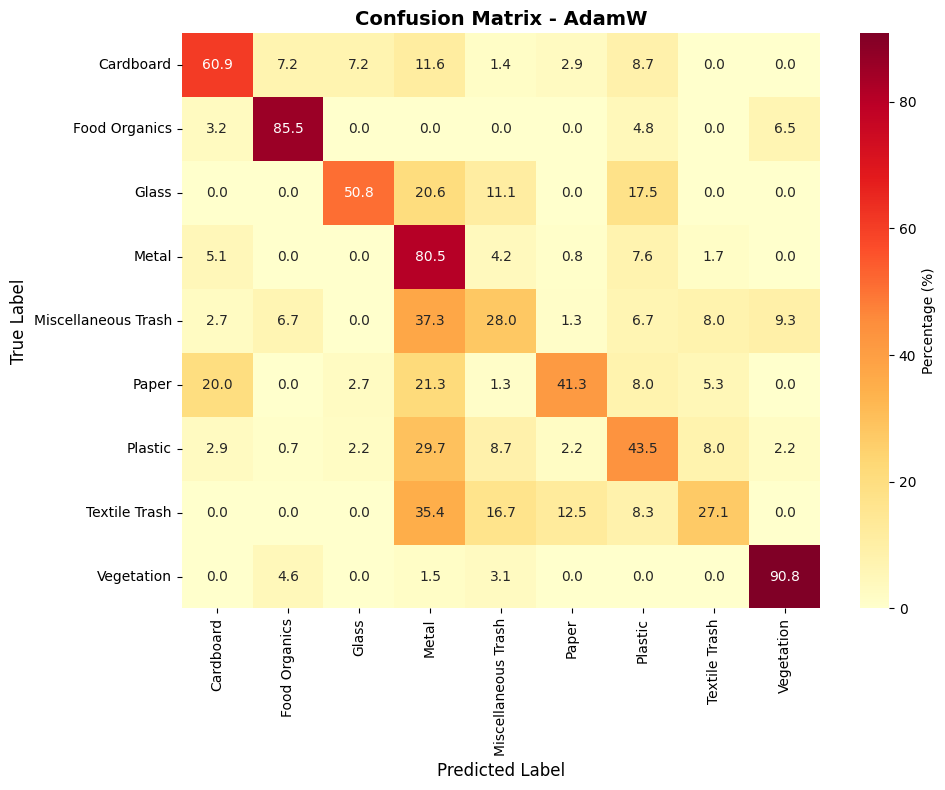


📊 AdamW Results:
  Train Accuracy: 56.64%
  Test Accuracy:  56.94%
  Precision:      0.5997
  Recall:         0.5648
  F1-Score:       0.5661



TRAINING WITH SGD
Epoch [ 1/20] | Train Loss: 2.2230 | Train Acc: 12.78% | Val Loss: 2.2074 | Val Acc: 23.14%
Epoch [ 2/20] | Train Loss: 2.2056 | Train Acc: 13.02% | Val Loss: 2.1922 | Val Acc: 18.37%
Epoch [ 3/20] | Train Loss: 2.1939 | Train Acc: 14.25% | Val Loss: 2.1722 | Val Acc: 17.95%
Epoch [ 4/20] | Train Loss: 2.1813 | Train Acc: 14.46% | Val Loss: 2.1573 | Val Acc: 17.95%
Epoch [ 5/20] | Train Loss: 2.1691 | Train Acc: 15.09% | Val Loss: 2.1438 | Val Acc: 16.97%
Epoch [ 6/20] | Train Loss: 2.1493 | Train Acc: 16.00% | Val Loss: 2.1219 | Val Acc: 17.67%
Epoch [ 7/20] | Train Loss: 2.1292 | Train Acc: 17.53% | Val Loss: 2.0981 | Val Acc: 18.37%
Epoch [ 8/20] | Train Loss: 2.1247 | Train Acc: 17.59% | Val Loss: 2.0949 | Val Acc: 18.37%
Epoch [ 9/20] | Train Loss: 2.1053 | Train Acc: 17.53% | Val Loss: 2.0781 | Val Acc: 19.92%
Epoch [1

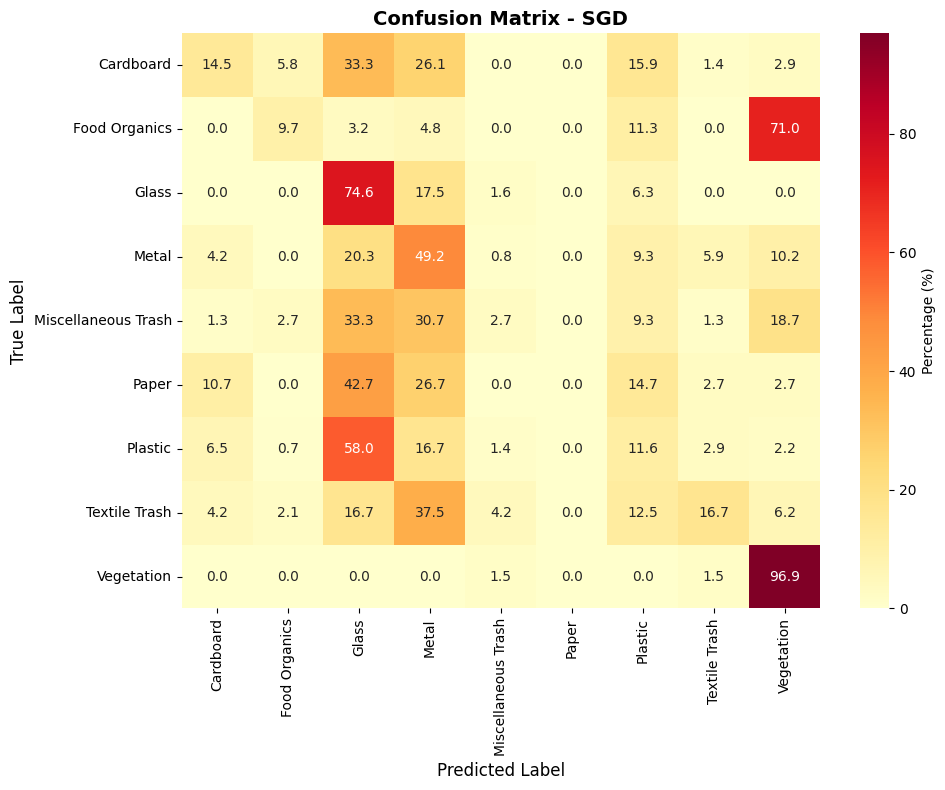


📊 SGD Results:
  Train Accuracy: 30.01%
  Test Accuracy:  29.45%
  Precision:      0.2731
  Recall:         0.3064
  F1-Score:       0.2315



TRAINING WITH SGD_MOMENTUM
Epoch [ 1/20] | Train Loss: 2.1944 | Train Acc: 14.37% | Val Loss: 2.1345 | Val Acc: 15.85%
Epoch [ 2/20] | Train Loss: 2.0715 | Train Acc: 21.98% | Val Loss: 1.9747 | Val Acc: 35.76%
Epoch [ 3/20] | Train Loss: 1.9431 | Train Acc: 28.32% | Val Loss: 1.8609 | Val Acc: 36.75%
Epoch [ 4/20] | Train Loss: 1.8180 | Train Acc: 34.85% | Val Loss: 1.8671 | Val Acc: 35.34%
Epoch [ 5/20] | Train Loss: 1.7571 | Train Acc: 37.25% | Val Loss: 1.7375 | Val Acc: 42.92%
Epoch [ 6/20] | Train Loss: 1.7058 | Train Acc: 41.19% | Val Loss: 1.5973 | Val Acc: 47.97%
Epoch [ 7/20] | Train Loss: 1.6357 | Train Acc: 45.64% | Val Loss: 1.6349 | Val Acc: 52.59%
Epoch [ 8/20] | Train Loss: 1.6168 | Train Acc: 46.57% | Val Loss: 1.7544 | Val Acc: 43.48%
Epoch [ 9/20] | Train Loss: 1.5681 | Train Acc: 47.90% | Val Loss: 1.4691 | Val Acc: 54.98%
E

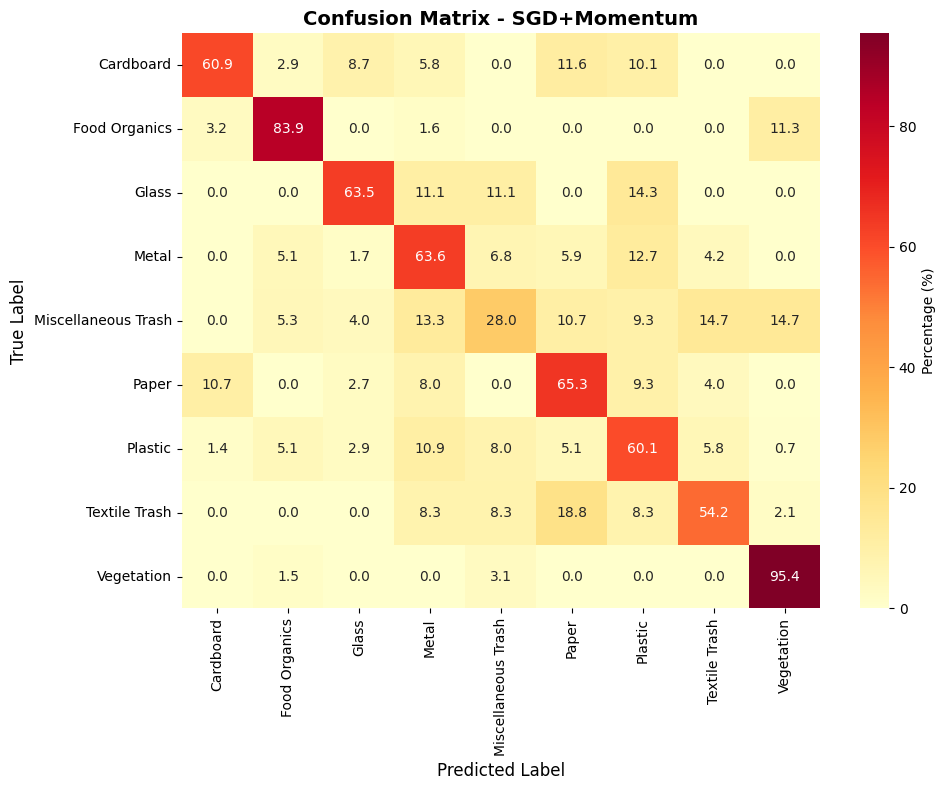


📊 SGD+Momentum Results:
  Train Accuracy: 60.46%
  Test Accuracy:  63.11%
  Precision:      0.6272
  Recall:         0.6387
  F1-Score:       0.6281




ValueError: 'blue--' is not a valid format string (unrecognized character 'l')

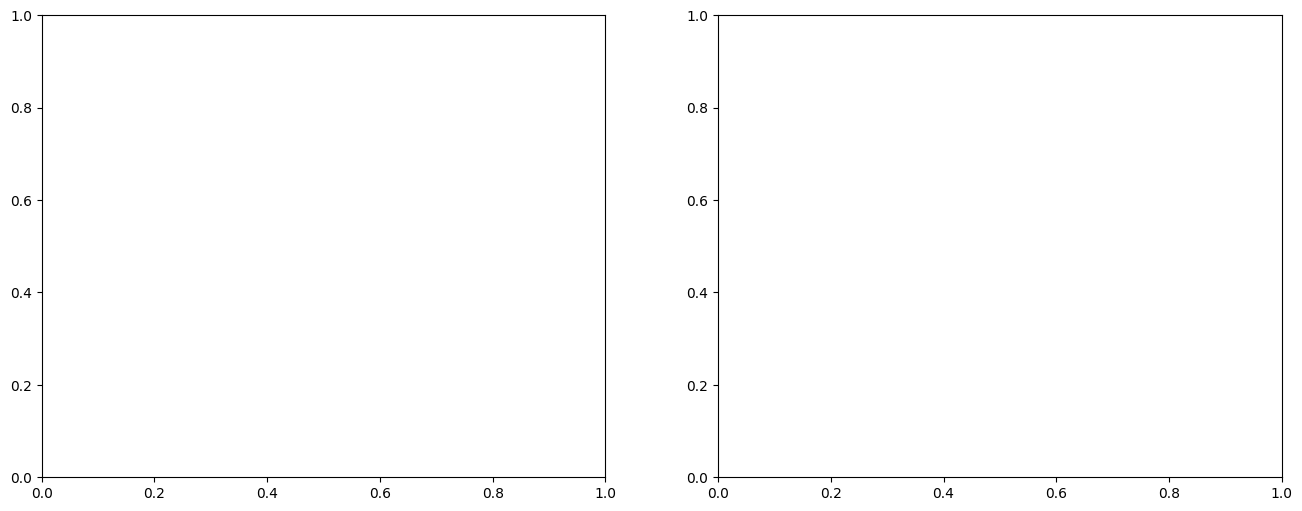

In [ ]:
print("\n" + "="*70)
print("OPTIMIZER COMPARISON")
print("="*70)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

optimizers_to_test = ['adamw', 'sgd', 'sgd_momentum']
optimizer_names = ['AdamW', 'SGD', 'SGD+Momentum']
histories = []
test_results = []

for opt_type, opt_name in zip(optimizers_to_test, optimizer_names):
    # Create fresh model
    model = WasteNetDeep(num_classes=NUM_CLASSES).to(device)
    
    # Train
    history, best_val_acc = train_model(
        model_name=f'wastenet_{opt_type}',
        optimizer_type=opt_type,
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        device=device,
        num_epochs=NUM_EPOCHS
    )
    
    histories.append(history)
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(f'best_wastenet_{opt_type}.pth'))
    
    # Evaluate on training set
    train_metrics = evaluate_model(model, train_loader, device, CLASS_NAMES)
    
    # Evaluate on test set
    test_metrics = evaluate_model(model, test_loader, device, CLASS_NAMES)
    
    test_results.append({
        'optimizer': opt_name,
        'train_acc': train_metrics['accuracy'],
        'test_acc': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1': test_metrics['f1'],
        'confusion_matrix': test_metrics['confusion_matrix']
    })
    
    # Plot confusion matrix
    plot_confusion_matrix(
        test_metrics['confusion_matrix'],
        CLASS_NAMES,
        opt_name,
        f'confusion_matrix_{opt_type}.png'
    )
    
    print(f"\n📊 {opt_name} Results:")
    print(f"  Train Accuracy: {train_metrics['accuracy']:.2f}%")
    print(f"  Test Accuracy:  {test_metrics['accuracy']:.2f}%")
    print(f"  Precision:      {test_metrics['precision']:.4f}")
    print(f"  Recall:         {test_metrics['recall']:.4f}")
    print(f"  F1-Score:       {test_metrics['f1']:.4f}")
    print("\n")


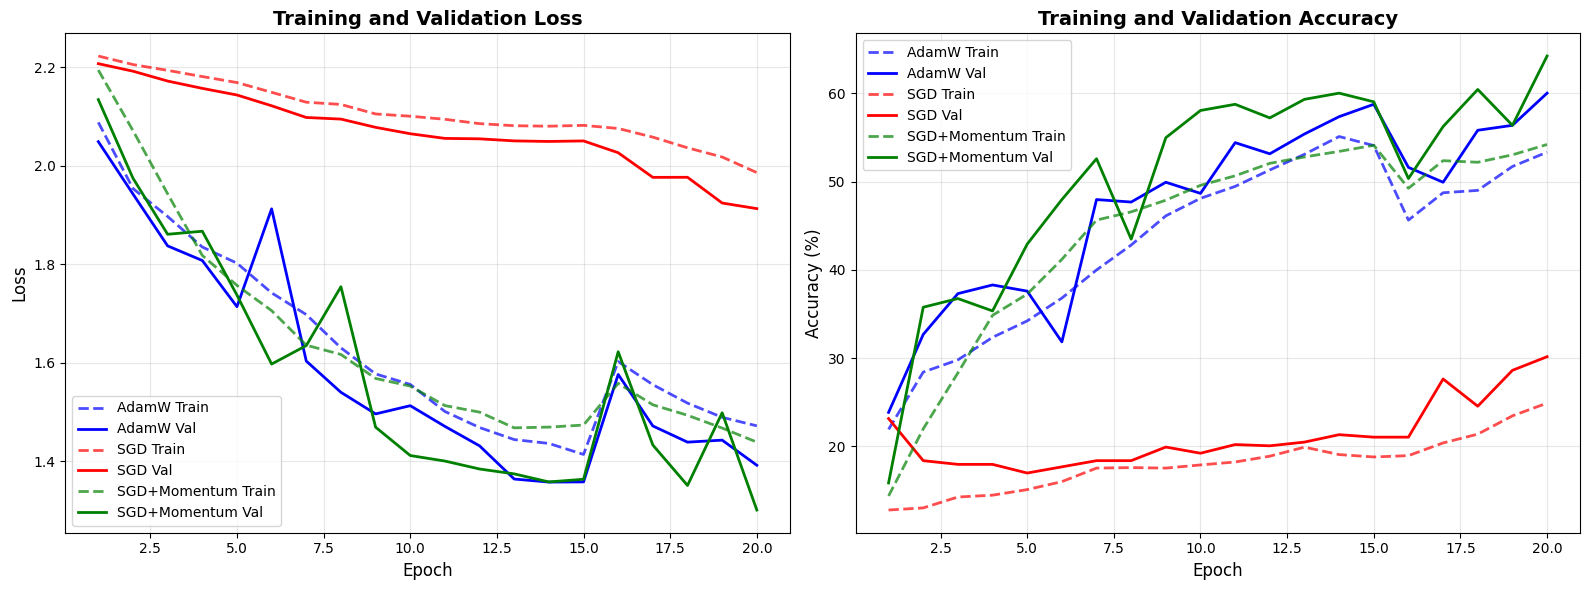


✅ Training curves saved to training_comparison.png


In [13]:
# Plot training curves comparison
plot_training_curves(histories, optimizer_names)

In [14]:
print("\n" + "="*70)
print("FINAL PERFORMANCE COMPARISON")
print("="*70)
print("\nMetrics Used:")
print("  1. Test Accuracy (primary metric)")
print("  2. Precision (macro-averaged)")
print("  3. Recall (macro-averaged)")
print("  4. F1-Score (macro-averaged)")
print("\n" + "-"*70)
print(f"{'Optimizer':<15} {'Train Acc':<12} {'Test Acc':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*70)

for result in test_results:
    print(f"{result['optimizer']:<15} "
          f"{result['train_acc']:>10.2f}% "
          f"{result['test_acc']:>10.2f}% "
          f"{result['precision']:>10.4f} "
          f"{result['recall']:>10.4f} "
          f"{result['f1']:>10.4f}")

print("="*70)

# Find best optimizer
best_result = max(test_results, key=lambda x: x['test_acc'])
print(f"\n🏆 Best Optimizer: {best_result['optimizer']}")
print(f"   Test Accuracy: {best_result['test_acc']:.2f}%")
print(f"   F1-Score: {best_result['f1']:.4f}")

print("\n✅ Experiment completed successfully!")


FINAL PERFORMANCE COMPARISON

Metrics Used:
  1. Test Accuracy (primary metric)
  2. Precision (macro-averaged)
  3. Recall (macro-averaged)
  4. F1-Score (macro-averaged)

----------------------------------------------------------------------
Optimizer       Train Acc    Test Acc     Precision    Recall       F1-Score    
----------------------------------------------------------------------
AdamW                56.64%      56.94%     0.5997     0.5648     0.5661
SGD                  30.01%      29.45%     0.2731     0.3064     0.2315
SGD+Momentum         60.46%      63.11%     0.6272     0.6387     0.6281

🏆 Best Optimizer: SGD+Momentum
   Test Accuracy: 63.11%
   F1-Score: 0.6281

✅ Experiment completed successfully!
